In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set()
sns.set_style("whitegrid")

out_file_path = "../../img/"


In [8]:
cu_data = pd.read_csv("../data/spgemm-cusparse-reuse-4090-15g.csv",
                      header=None,
                      names=[
                          "cu_pro", "mat", "x", "y", "compute", "m", "n", "nnz",
                          "cu_time","cu_gflops",
                      ])
cu_data=cu_data.loc[:,["cu_pro", "mat", "nnz", "cu_time"]]

work_est = pd.read_csv("../data/spgemm-work-est-cbd.csv",
                      header=None,
                      names=[
                          "mat", "flops",
                      ])
                      
cu_data = pd.merge(cu_data, work_est, how='inner', on='mat')

cu_data["cu_gflops"] = 2 * cu_data["flops"] / cu_data["cu_time"] / 1e6

rate_data = pd.read_csv("../data/tile-ana-.csv",
                      header=None,
                      names=[
                          "id","mat","m_","n_","nnz_","rate","cu_gflops_32_","cu_gflops_64_","cu_gflops_16_","speedup_32_","speedup_16_"
                      ]
                      )
rate_data=rate_data.loc[:,["mat", "rate",]]

cu_data = pd.merge(cu_data, rate_data, how='inner', on='mat')
# print(cu_data)

cu_info = cu_data["cu_pro"].unique()

for diff_pro in cu_info:
    temp_data = cu_data[cu_data["cu_pro"].isin([diff_pro])]
    exec("%s=temp_data.copy()" % diff_pro)
print(cu_info)

['exe_spgemm_cusparse_16' 'exe_spgemm_cusparse_32'
 'exe_spgemm_cusparse_64']


In [9]:
speck_data = pd.read_csv("../data/speck-4090.csv",
                      header=None,
                      names=[
                          "speck_pro", "mat", "m", "n", "nnz",
                          "inter", "speck_time","self_time",
                      ])
speck_data=speck_data.loc[:,["speck_pro", "mat", "nnz", "speck_time"]]

speck_data = pd.merge(speck_data, work_est, how='inner', on='mat')
speck_data["speck_gflops"] = 2 * speck_data["flops"] / speck_data["speck_time"] / 1e6

speck_data = pd.merge(speck_data, rate_data, how='inner', on='mat')

speck_info = speck_data["speck_pro"].unique()

for diff_pro in speck_info:
    temp_data = speck_data[speck_data["speck_pro"].isin([diff_pro])]
    exec("%s=temp_data.copy()" % diff_pro)
print(speck_info)

['exe_spgemm_speck_32' 'exe_spgemm_speck_64']


In [10]:
tile_data = pd.read_csv("../data/tile-4090.csv",
                      header=None,
                      names=[
                          "tile_pro", "mat", "x", "y", "compute", "m", "n", "nnz",
                          "tile_time", "tile_gflops", "rate", "des"
                      ])
tile_data=tile_data.loc[:,["tile_pro", "mat", "nnz", "tile_time", "tile_gflops", "rate"]]

tile_info = tile_data["tile_pro"].unique()

for diff_pro in tile_info:
    temp_data = tile_data[tile_data["tile_pro"].isin([diff_pro])]
    exec("%s=temp_data.copy()" % diff_pro)
print(tile_info)

['exe_spgemm_tile_32' 'exe_spgemm_tile_64']


In [11]:
cu_data_64 = exe_spgemm_cusparse_64[["mat", "cu_gflops", "rate", "flops"]]
cu_data_32 = exe_spgemm_cusparse_32[["mat", "cu_gflops"]]
cu_data_16 = exe_spgemm_cusparse_16[["mat", "cu_gflops"]]
# cu_data_bf16 = exe_spgemm_cusparse_bf16[["mat", "cu_gflops"]]

cu_data_comp = pd.merge(cu_data_64, cu_data_32, how='inner', on='mat', suffixes=("_64",""))
cu_data_comp = pd.merge(cu_data_comp, cu_data_16, how='inner', on='mat', suffixes=("_32","_16"))
# cu_data_comp = pd.merge(cu_data_comp, cu_data_bf16, how='inner', on='mat', suffixes=("_16","_bf16"))

cu_data_comp["speedup_32"] = cu_data_comp["cu_gflops_32"] / cu_data_comp["cu_gflops_64"]
cu_data_comp["speedup_16"] = cu_data_comp["cu_gflops_16"] / cu_data_comp["cu_gflops_64"]
# cu_data_comp["speedup_bf16"] = cu_data_comp["cu_gflops_bf16"] / cu_data_comp["cu_gflops_64"]

cu_data_comp = cu_data_comp.loc[(cu_data_comp["flops"] > 10e7)].copy()

# print(cu_data_comp)

In [12]:
speck_data_64 = exe_spgemm_speck_64[["mat", "speck_gflops", "rate", "flops"]]
speck_data_32 = exe_spgemm_speck_32[["mat", "speck_gflops"]]

speck_data_comp = pd.merge(speck_data_64, speck_data_32, how='inner', on='mat', suffixes=("_64","_32"))

speck_data_comp["speedup_32"] = speck_data_comp["speck_gflops_32"] / speck_data_comp["speck_gflops_64"]

speck_data_comp = speck_data_comp.loc[(speck_data_comp["flops"] > 10e7)].copy()

# print(speck_data_comp)

In [13]:
tile_data_64 = exe_spgemm_tile_64[["mat", "tile_gflops", "rate"]]
tile_data_32 = exe_spgemm_tile_32[["mat", "tile_gflops"]]

tile_data_comp = pd.merge(tile_data_64, tile_data_32, how='inner', on='mat', suffixes=("_64","_32"))

tile_data_comp["speedup_32"] = tile_data_comp["tile_gflops_32"] / tile_data_comp["tile_gflops_64"]

# print(tile_data_comp)

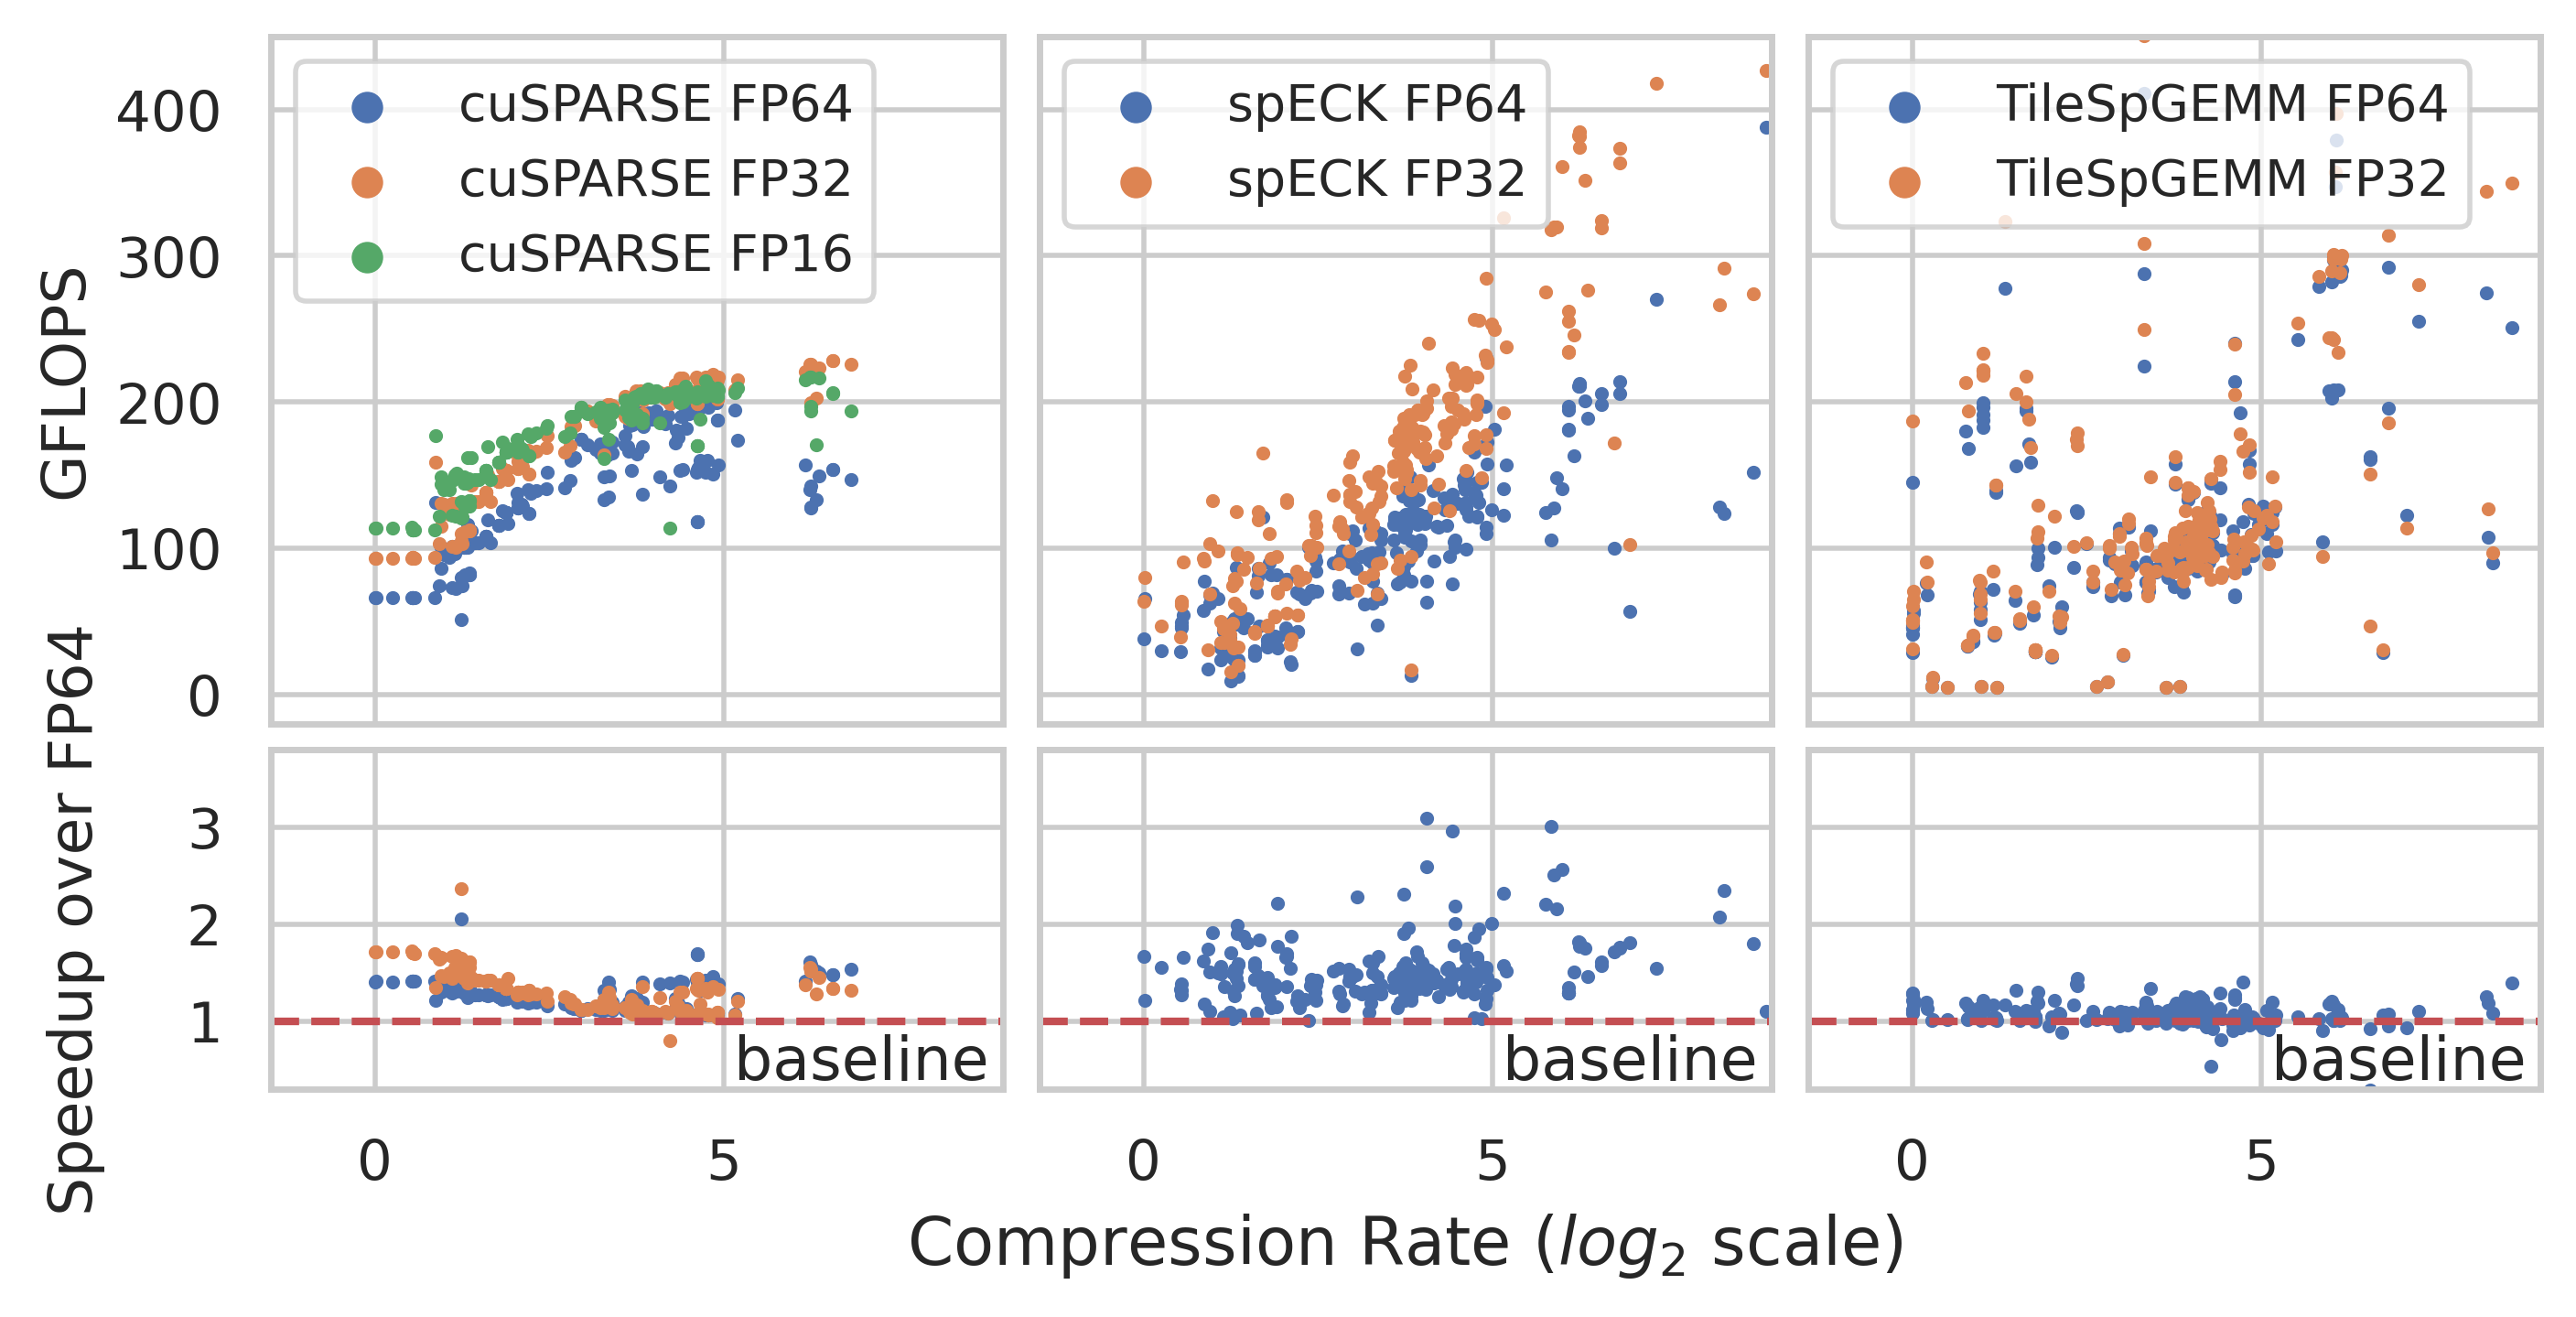

In [14]:
# plt.figure(figsize=(15, 10), dpi=400)
plt.figure(figsize=(8, 5), dpi=400)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

dot_size = 3
legend_font_size = 10

plt.subplot(231)

plt.scatter(np.log2(cu_data_comp["rate"]),
            (cu_data_comp["cu_gflops_64"]),
            label="cuSPARSE FP64",
            s=dot_size,
            )
plt.scatter(np.log2(cu_data_comp["rate"]),
            (cu_data_comp["cu_gflops_32"]),
            label="cuSPARSE FP32",
            s=dot_size,
            )
plt.scatter(np.log2(cu_data_comp["rate"]),
            (cu_data_comp["cu_gflops_16"]),
            label="cuSPARSE FP16",
            s=dot_size,
            )

plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)
plt.xlim(-1.5, 9)
plt.ylim(-20, 450)

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
# plt.xlabel("Compression Rate (log scale)")

plt.ylabel("GFLOPS")

# --------------------------------------------------------------------------------------------

plt.subplot(232)

plt.scatter(np.log2(speck_data_comp["rate"]),
            (speck_data_comp["speck_gflops_64"]),
            label="spECK FP64",
            s=dot_size,
            )
plt.scatter(np.log2(speck_data_comp["rate"]),
            (speck_data_comp["speck_gflops_32"]),
            label="spECK FP32",
            s=dot_size,
            )

plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)
plt.xlim(-1.5, 9)
plt.ylim(-20, 450)

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# --------------------------------------------------------------------------------------------

plt.subplot(233)

plt.scatter(np.log2(tile_data_comp["rate"]),
            (tile_data_comp["tile_gflops_64"]),
            label="TileSpGEMM FP64",
            s=dot_size,
            )
plt.scatter(np.log2(tile_data_comp["rate"]),
            (tile_data_comp["tile_gflops_32"]),
            label="TileSpGEMM FP32",
            s=dot_size,
            )

plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)
plt.xlim(-1.5, 9)
plt.ylim(-20, 450)

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# --------------------------------------------------------------------------------------------

plt.subplot(437)

plt.scatter(
            np.log2(cu_data_comp["rate"]),
            (cu_data_comp["speedup_32"]),
            label="cuSPARSE\nFP32 speedup over FP64",
            s=dot_size)
plt.scatter(
            np.log2(cu_data_comp["rate"]),
            (cu_data_comp["speedup_16"]),
            label="FP16 speedup over FP64",
            s=dot_size)


text_her_loc = 8.8
text_ver_loc = -0.6
plt.axhline(1, color="r", linestyle="--")
plt.text(text_her_loc, 1 + text_ver_loc, 'baseline', horizontalalignment="right")
plt.xlim(-1.5, 9)
plt.ylim(0.3, 3.8)
# plt.xlabel("Compression Rate (log scale)")
plt.ylabel("Speedup over FP64",labelpad=16)

# plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)

# --------------------------------------------------------------------------------------------

plt.subplot(438)

plt.scatter(np.log2(speck_data_comp["rate"]),
            (speck_data_comp["speedup_32"]),
            label="spECK\nFP32 speedup over FP64",
            s=dot_size)

plt.axhline(1, color="r", linestyle="--")
plt.text(text_her_loc, 1 + text_ver_loc, 'baseline', horizontalalignment="right")
plt.xlim(-1.5, 9)
plt.ylim(0.3, 3.8)

# plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)

plt.xlabel("Compression Rate ($log_2$ scale)",fontsize=13)
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])

# --------------------------------------------------------------------------------------------

plt.subplot(439)

plt.scatter(np.log2(tile_data_comp["rate"]),
            (tile_data_comp["speedup_32"]),
            label="TileSpGEMM\nFP32 speedup over FP64",
            s=dot_size)

plt.axhline(1, color="r", linestyle="--")
plt.text(text_her_loc, 1 + text_ver_loc, 'baseline', horizontalalignment="right")
plt.xlim(-1.5, 9)
plt.ylim(0.3, 3.8)

# plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)

# plt.xlabel("Compression Rate (log scale)")
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])

# --------------------------------------------------------------------------------------------

# plt.show()
plt.savefig ("spgemm_4090.pdf", dpi= 400, format = "pdf", bbox_inches='tight', pad_inches=0.0) 


In [15]:
print("cu spgemm fp16 speedup max: ", max(cu_data_comp["speedup_16"]))
print("cu spgemm fp32 speedup max: ", max(cu_data_comp["speedup_32"]))

print("speck spgemm fp32 speedup max: ", max(speck_data_comp["speedup_32"]))

print("tile spgemm fp32 speedup max: ", max(tile_data_comp["speedup_32"]))

print("cu spgemm fp16 max: ", max(cu_data_comp["cu_gflops_16"]))
print("cu spgemm fp32 max: ", max(cu_data_comp["cu_gflops_32"]))
print("cu spgemm fp64 max: ", max(cu_data_comp["cu_gflops_64"]))

print("speck spgemm fp32 max: ", max(speck_data_comp["speck_gflops_32"]))
print("speck spgemm fp64 max: ", max(speck_data_comp["speck_gflops_64"]))

print("tile spgemm fp32 max: ", max(tile_data_comp["tile_gflops_32"]))
print("tile spgemm fp64 max: ", max(tile_data_comp["tile_gflops_64"]))


cu spgemm fp16 speedup max:  2.369339746792952
cu spgemm fp32 speedup max:  2.0552544504003705
speck spgemm fp32 speedup max:  3.0957662218131614
tile spgemm fp32 speedup max:  1.4370663196670364
cu spgemm fp16 max:  217.0046602716055
cu spgemm fp32 max:  228.39350477826693
cu spgemm fp64 max:  202.625082650697
speck spgemm fp32 max:  426.3289119255674
speck spgemm fp64 max:  388.1196132318434
tile spgemm fp32 max:  450.706194
tile spgemm fp64 max:  410.898131
